In [1]:
name = '2015-03-02-pmc-trajectories'
title = 'Polar lows trajectories as colored 2D lines on a map'
tags = 'python, dataviz, meteorology, polar lows'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags)

**Task:** plot several trajectories on a map, colour them according to date and time, create a common colorbar

**Tools:** Python 2.7.6, Matplotlib 1.4.2 (Basemap, dates, LineCollection, pyplot), optional - Pandas
    
Using [the script](http://dennissergeev.github.io/satellite-imagery-viewer-in-python.html) that I wrote before, I tracked all the polar mesoscale cyclones (**PMC**) over the Nordic Seas that were distinguishable in the AVHRR satellite images during the ACCACIA campaign. After this highly subjective work I decided to plot the resulting locations of the polar lows at the corresponding time moments.

Below are bits of code that I used to fiddle with Python’s matplotlib module to create this mess:

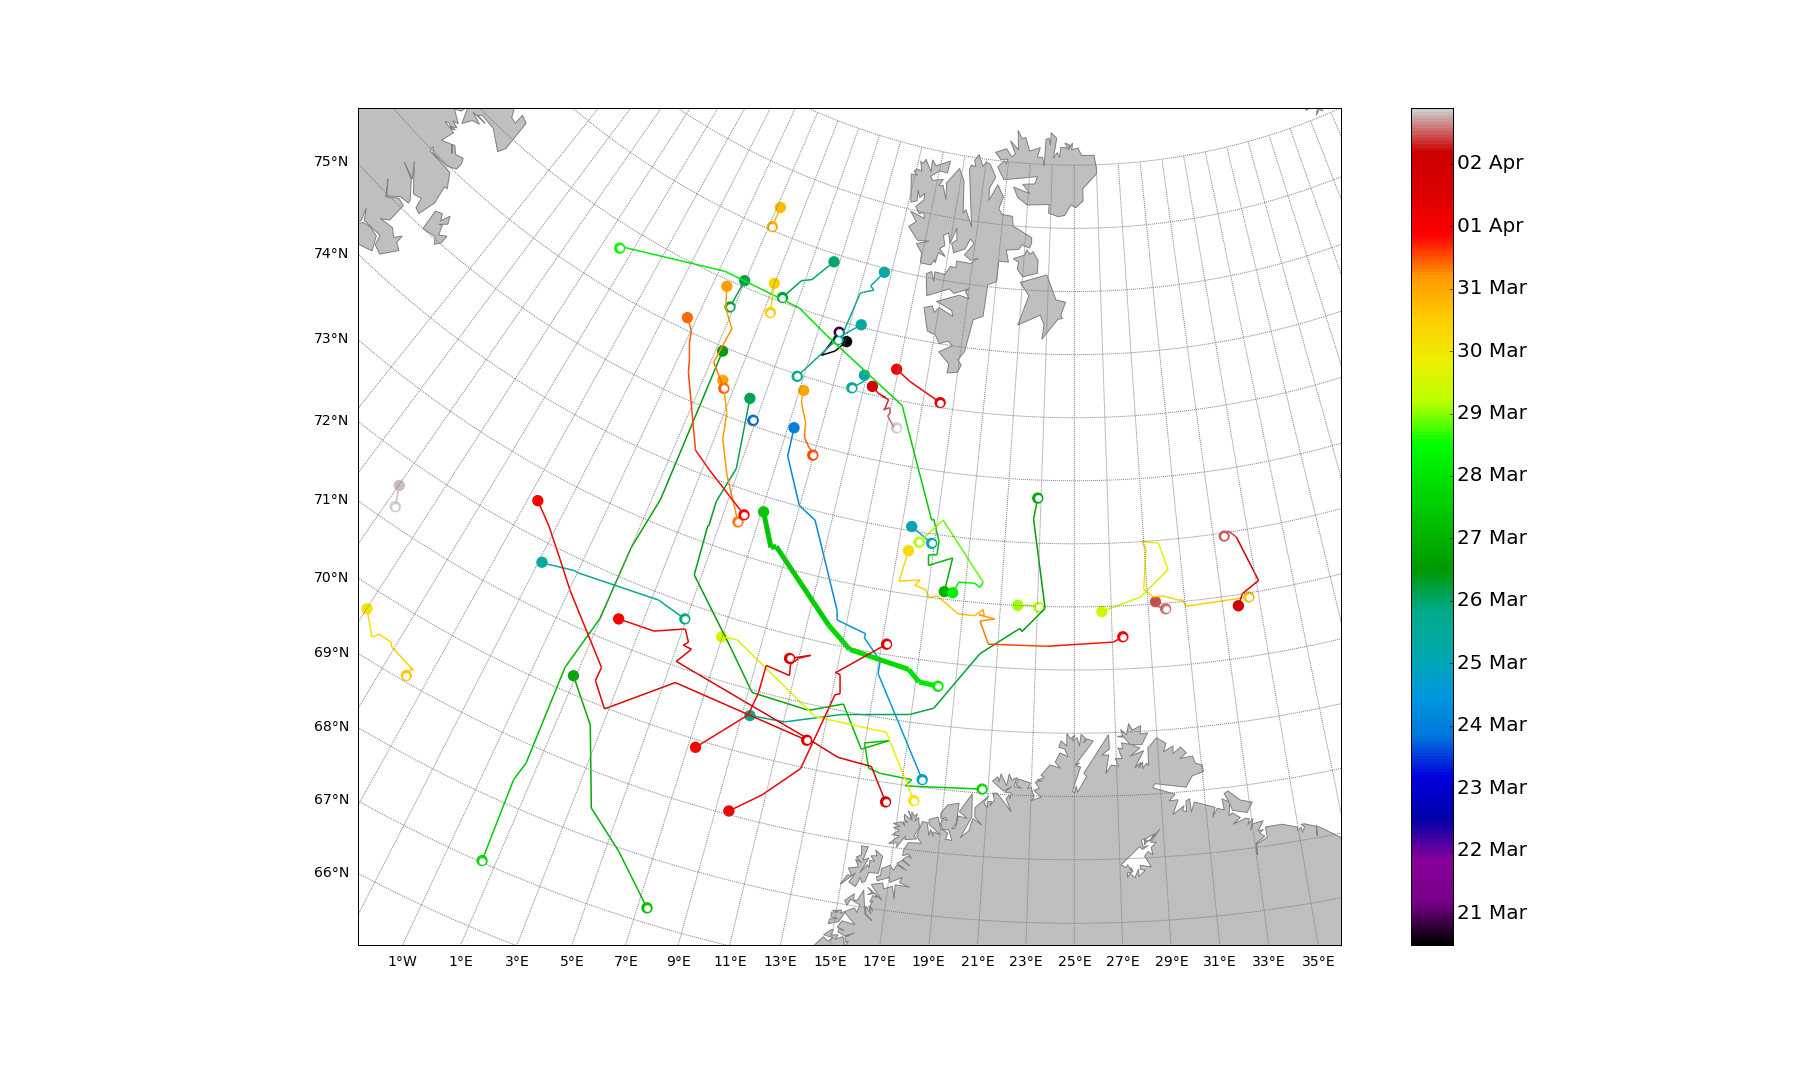

In [3]:
from IPython.core.display import Image
Image('../figures/pmc_traj_example.png', retina=True)

*Polar mesoscale cyclones trajectories coloured by their time. Closed circles denote the first occurrence, open circles – the last occurrence in the satellite imagery. PMC \#15 is marked by a bold green line and also appears in the table below.*

##Reading and organising data

To begin with, let’s import all the necessary modules, starting with `matplotlib` magic:

In [4]:
%matplotlib inline

In [5]:
import datetime
import LatLon as LL # for fancy coordinates notation
from matplotlib import dates, collections
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as mcm
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

Next, I define a couple of useful functions that will be used later. 

In [6]:
def deg2name(num_deg, nbins=16):
    """
    Convert degrees to compass names
    """
    assert type(num_deg) != np.str, 'Input cannot be of string type'
    assert nbins==16 or nbins==8 or nbins==4, 'Number of bins must be 4, 8 or 16'
    db = 16/nbins
    deg_lev = np.linspace(0,360,nbins+1)
    deg_bound = deg_lev[1::] - deg_lev[1]/2.
    compass = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW'][::db]

    if not hasattr(num_deg,'__iter__'):
        for j in xrange(len(deg_bound)):
            if deg_bound[j-1] < num_deg <= deg_bound[j]:
                out_deg = compass[j]
            if deg_bound[-1] < num_deg or num_deg <= deg_bound[0]:
                out_deg = compass[0]
     
    elif type(num_deg) is list:
        out_deg = []
        for i in num_deg:
            for j in xrange(len(deg_bound)-1):
                if deg_bound[j] < i <= deg_bound[j+1]:
                    out_deg.append(compass[j+1])
            if deg_bound[-1] < i or i <= deg_bound[0]:
                out_deg.append(compass[0])
     
    else:
        raise TypeError('Handling input of type '+type(num_deg).__name__+' is not implemented yet')

    return out_deg

def num2lat(deg_lat):
    return LL.Latitude(deg_lat).to_string("d%$^\circ$%m%'%H")
    
def num2lon(deg_lon):
    return LL.Longitude(deg_lon).to_string("d%$^\circ$%m%'%H")

This function will be used to convert direction of PMC propagation to a more 'human' notation. But first I needed to calculate the direction, as well as the speed and the distance of PMCs. For this purpose the Earth's radius is needed:

In [7]:
r_earth  = 6.371e6 # Earth radius [m]

Time to load data!

In [8]:
dat = np.loadtxt('../data/pmc_loc_time_ch4_20Mar-02Apr.txt', delimiter="\t")

Find unique PMCs:

In [9]:
ids = [int(i) for i in set(dat[:,0])]

Now, for convenience, I constructed a `pmc` class that stores parameters of each PMC. Just to be clear, all the data is in a list (`pmc_list`) of objects of `pmc` class that have such attributes as id (`pmc.n`), latitude (`pmc.lat`), longitude (`pmc.lon`) and time string (`pmc.dt`), which is simply year, month, day, hour and minute of a satellite image.

The `pmc` class also has a few internal functions used to calculate the distance, velocity and direction (in meteorological convention) of PMC movement.

In [10]:
class pmc:
    def __init__(self,n,dat):
        self.n = n
        self.dt = [datetime.datetime.strptime(str(int(i)),'%Y%m%d%H%M') for i in dat[dat[:,0]==n,1]]
        self.lon = [i for i in dat[dat[:,0]==n,2]]
        self.lat = [i for i in dat[dat[:,0]==n,3]]
        self.dist = []
        self.vel = []
        if len(zip(self.lon,self.lat)) > 1:
            self.calc_dist(r_earth)
            self.calc_vel()
            self.calc_met_dir()
            self.calc_vel_uv()
        
    def calc_dist(self,r):
        lon = np.radians(self.lon)
        lat = np.radians(self.lat)
        self.dist = []
        for i in xrange(len(zip(lon,lat))-1):
            if lat[i+1] == lat[i] and lon[i+1] == lon[i]:
                self.dist.append(0.)
            else:
                self.dist.append(np.arccos(np.sin(lat[i])*np.sin(lat[i+1]) + \
                                           np.cos(lat[i])*np.cos(lat[i+1])*np.cos(lon[i]-lon[i+1])))
        self.dist = r*np.array(self.dist)

    def calc_vel(self):
        self.mean_vel = self.dist.sum()/(self.dt[-1]-self.dt[0]).total_seconds()
        self.vel = []
        for i in xrange(len(self.dt)-1):
            if self.dt[i] == self.dt[i+1]:
                self.vel.append(None)
            else:
                self.vel.append(self.dist[i]/(self.dt[i+1]-self.dt[i]).total_seconds())
        self.vel = np.array(self.vel)
        
    def calc_met_dir(self):
        self.mean_prop_dir = 180 + \
        180./np.pi*np.arctan2(self.lon[-1]-self.lon[0], self.lat[-1]-self.lat[0])
        self.prop_dir = []
        for i in xrange(len(self.dt)-1):
            if self.dt[i] == self.dt[i+1]:
                self.prop_dir.append(None)
            else:
                dlon = self.lon[i+1] - self.lon[i]
                dlat = self.lat[i+1] - self.lat[i]
                self.prop_dir.append(180 + 180./np.pi*np.arctan2(dlon, dlat))
                
    def calc_vel_uv(self):
        assert hasattr(self,'vel'), self.calc_vel()
        assert hasattr(self,'prop_dir'), self.calc_met_dir()
        
        self.prop_u = []
        self.prop_v = []
        for i in xrange(len(self.dt)-1):
            self.prop_u.append(-self.vel[i]*np.sin(np.radians(self.prop_dir[i])))
            self.prop_v.append(-self.vel[i]*np.cos(np.radians(self.prop_dir[i])))

In the following loop a list of PMCs is created:

In [11]:
pmc_list = []
for j in ids:
    pmc_list.append(pmc(j,dat))

In other words, each PMC (e.g., \#11) initially can be represented as the table below:

In [12]:
print 'PMC No.{}'.format(pmc_list[13].n)
print
for j, k, l in zip(pmc_list[13].lon, pmc_list[13].lat, pmc_list[13].dt):
    print j, k, l

PMC No.15

7.116 73.758 2013-03-27 10:28:00
8.087 73.25 2013-03-27 12:00:00
8.348 73.29 2013-03-27 12:07:00
12.115 72.285 2013-03-27 18:31:00
13.432 71.978 2013-03-27 20:10:00
16.559 71.823 2013-03-28 00:20:00
17.171 71.648 2013-03-28 02:02:00
18.14 71.619 2013-03-28 03:43:00


With the functions inside of the `pmc` class and additional converterting function `deg2name` I calculated different parameters of PMCs. The result is presented in the following `pandas` dataframe:

In [13]:
table = pd.DataFrame(data=zip(['{0:4.1f}, {1:4.1f}'.format(i.lat[0],i.lon[0]) for i in pmc_list],
                              ['{0:4.1f}, {1:4.1f}'.format(i.lat[-1],i.lon[-1]) for i in pmc_list],
                              ['{0:4.1f}'.format(i.mean_vel*3.6) if hasattr(i,'mean_vel') else None for i in pmc_list],
                              ['{0}'.format((i.dt[-1]-i.dt[0])) for i in pmc_list],
                              ['{0:6.1f}'.format(sum(i.dist)/1000.) for i in pmc_list],
                              [deg2name(i.mean_prop_dir) if hasattr(i,'mean_prop_dir') else None for i in pmc_list]),
                     index=[i.n for i in pmc_list],
                     columns=['start','finish','mean speed (km/h)','life time (h)','distance (km)','direction'])
table.head(5)

,start,finish,mean speed (km/h),life time (h),distance (km),direction
1,"76.7, 9.1","76.8, 8.4",13.6,7:33:00,103.0,E
3,"75.2, 7.4","70.1, 17.9",37.7,18:29:00,696.1,WNW
4,"74.1, 15.6","73.9, 16.8",27.1,1:42:00,46.0,W
5,"77.9, 10.5","76.7, 8.5",23.7,6:47:00,160.5,ENE
6,"77.0, 9.8","76.0, 6.6",14.5,10:02:00,145.9,ENE


##Plotting PMC trajectories on a map

Here is the part where the trajectories of PMCs are plotted on a map and coloured by their occurence in time. To make date and time a colormap parameter, I firstly needed to convert datetime list for each of them to a number using `matplotlib.dates` module, flattening the list of list into a single list:

In [14]:
mdt = [k for j in [dates.date2num(i.dt) for i in pmc_list] for k in j]

Next step is to select a colormap and normalise it to the dates range. It's also to make sure that colorbar limits are set for all time period, not just for any of the PMCs.

In [15]:
cmap_name = 'nipy_spectral'
cmap = plt.get_cmap(cmap_name) 
cNorm  = mcol.Normalize(mdt[0],mdt[-1])

By default `matplotlib` does not have a multicolored line function, analogous to the 2D line plot. Luckily, this question have been asked on Stack Overflow and has a brilliant [notebook](http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb) covering different applications of the function. I merely adapted the solution to suit my needs.

In [16]:
def colorline(x, y, z=None, cmap='Spectral', norm=None, linewidth=3, alpha=1.0):
    """
    Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
    The color is taken from optional data in z, and creates a LineCollection.
    z can be:
    - empty, in which case a default coloring will be used based on the position along the input arrays
    - a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
    - an array of the length of at least the same length as x, to color according to this data
    - an array of a smaller length, in which case the colors are repeated along the curve
    The function colorline returns the LineCollection created, which can be modified afterwards.
    """
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    if norm is None:
        norm=plt.Normalize(np.min(z),np.max(z))

    lc = collections.LineCollection(segments, array=z, cmap=plt.get_cmap(cmap), norm=norm, linewidth=linewidth, alpha=alpha)

    plt.gca().add_collection(lc)
    return lc

Using `Basemap`, a simple map with Lambert Conformal Conic projection is created.

In [17]:
lon1 = -2.5
lon2 = 50.
lat1 = 65.
lat2 = 80.

m = Basemap(projection='lcc',\
            llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,\
            lat_1=lat1+2./3*(lat2-lat1),lat_2=lat2,lon_0=0.5*(lon1+lon2),\
            resolution='l')

Below is the rest of plotting code. Besides the colored lines, I also wanted to show the first and the last occurrence of a PMC (i.e. the start and the finish location) painted in a respective colour. I used `Basemap.scatter` function with similar techniques as for the `colorline`.

Another code line is necessary to mark the finish locations with an open circle (there’s probably an option for that in the scatter function itself).

The last and a very important step is to add a colorbar. The ticks and format keywords are assigned to the `matplotlib.dates` formats - this allows us to make the ticks at every 1 day interval and label them with a day-month string.

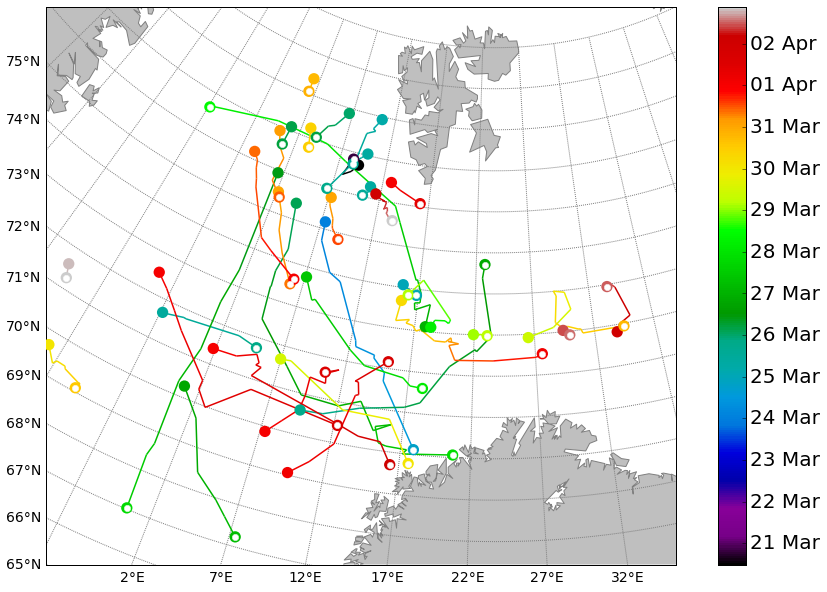

In [18]:
fig = plt.figure(figsize=(15,10))
# Draw some map features
m.drawmeridians(np.arange(round(lon1-20),lon2+20,5),labels=[0,0,0,1],size=14,color='0.5')
m.drawparallels(np.arange(round(lat1-10),lat2+10,1),labels=[1,0,0,0],size=14,color='0.5')
m.drawcoastlines(color='0.5')
m.fillcontinents(color='0.75')

# Plot parameters
msz = 6
kwds_line = dict(cmap=cmap_name, norm=cNorm, linewidth=1.5)
kwds_sctr = dict(cmap=cmap_name, norm=cNorm, edgecolors='none', s=2**(msz+1))
kwds_pnts = dict(marker='o', ms=msz, mfc='w', mec='w', linestyle='')

# Plot colored trajectories for each PMC
for j, i in enumerate(pmc_list):
    x, y = m(i.lon, i.lat)
    traj = colorline(x, y, dates.date2num(i.dt), **kwds_line)
    traj.set_zorder(100)

# Plot start/end location of each trajectory (empty dot for the end location)
# zorder keyword sets the objects on top of the map
fds_beg = [dates.date2num(i.dt[0]) for i in pmc_list]
fds_fin = [dates.date2num(i.dt[-1]) for i in pmc_list]
lon_beg = [i.lon[0] for i in pmc_list]
lat_beg = [i.lat[0] for i in pmc_list]
lon_fin = [i.lon[-1] for i in pmc_list]
lat_fin = [i.lat[-1] for i in pmc_list]
x_beg, y_beg = m(lon_beg, lat_beg)
x_fin, y_fin = m(lon_fin, lat_fin)
_ = m.scatter(x_beg, y_beg, c=fds_beg, zorder=101, **kwds_sctr)
_ = m.scatter(x_fin, y_fin, c=fds_fin, zorder=102, **kwds_sctr)
whtdots,  = m.plot(x_fin, y_fin, **kwds_pnts)
whtdots.set_zorder(103)

# Make colorbar with ticks formatted as day and month combination
cb = plt.colorbar(traj,shrink=1., orientation='vertical',
                  ticks=dates.DayLocator(interval=1), 
                  format=dates.DateFormatter('%d %b')) 
cb.ax.tick_params(labelsize=20)

Voila!

## Another example: direction as mappable variable

Besides date and times as 'arguments' for `matplotlib`'s colormap, another not very trivial example is to color the trajectories piecewisely according to the direction of their movement. Note: the direction is given in a meteorological notation.

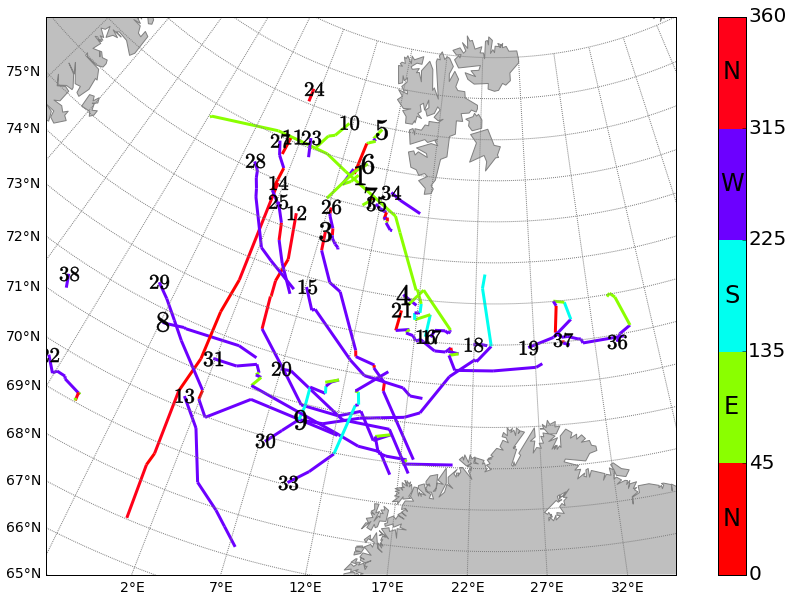

In [19]:
cmap_name360 = 'hsv' # Circular colormap
angles = [0,45,135,225,315,360] # 4 (5) compass segments
cmap360 = plt.get_cmap(cmap_name) 
cNorm360 = mcol.BoundaryNorm(angles,cmap360.N)

fig = plt.figure(figsize=(15,10))
# Draw some map features
m.drawmeridians(np.arange(round(lon1-20),lon2+20,5),labels=[0,0,0,1],size=14,color='0.5')
m.drawparallels(np.arange(round(lat1-10),lat2+10,1),labels=[1,0,0,0],size=14,color='0.5')
m.drawcoastlines(color='0.5')
m.fillcontinents(color='0.75')

# Plot parameters
msz = 6
kwds_line = dict(cmap=cmap_name360, norm=cNorm360, linewidth=3)

# Plot colored trajectories for each PMC
for j, i in enumerate(pmc_list):
    x, y = m(i.lon, i.lat)
    if hasattr(i,'prop_dir'):
        traj = colorline(x, y, i.prop_dir, **kwds_line)

# Plot id of each PMC
lon_beg = [i.lon[0] for i in pmc_list]
lat_beg = [i.lat[0] for i in pmc_list]
x_beg, y_beg = m(lon_beg, lat_beg)
[m.plot(x_beg[n], y_beg[n], marker=r"${}$".format(i.n), mec='k', mfc='k', ms=20) for n, i in enumerate(pmc_list)]

# Create a colorbar
cb = plt.colorbar(traj, shrink=1., orientation='vertical') 
cb.ax.tick_params(labelsize=20)

# Add compass notations inside the colorbar 
for j, lab in enumerate(['N','E','S','W','N']):
    cb.ax.text(.5, (2*j + 1) / 10.0, lab, ha='center', va='center', fontsize=24)

Looks a bit ugly, but whatever...

In [20]:
HTML(html)